# Imports and Settings

In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import math

mpl.rcParams['font.family'] = 'monospace'
mpl.rcParams['font.size'] = 11
palette = sns.color_palette("tab10", 10)

# Plot Utils
useful functions to visualize two-dimensional vectors and matrices

In [2]:
def plot_inputs(input_dict, figsize=(22, 5), linewidth=2.0):
  plotlim = 2.5
  fig, axs = plt.subplots(1, len(input_dict.keys()), figsize=figsize)
  for i, (ax, input_name) in enumerate(zip(axs, input_dict.keys())):
    axs[i].scatter(
                        input_dict[input_name][:,0].numpy(),
                        input_dict[input_name][:,1].numpy(),
                        s=15,
                        )
    for j in range(input_dict[input_name].shape[0]):
      x = input_dict[input_name][j,0]
      y = input_dict[input_name][j,1]
      axs[i].annotate(f"{input_name}_{j} ({round(x.item(),1)},{round(y.item(),1)})", (x+0.1, y+0.1))
      if input_name in ["key", "value"]:
        axs[i].plot([0,x], [0,y], ls='solid', c=palette[-j],linewidth=linewidth)
      else:
        axs[i].plot([0,x], [0,y], ls='solid', c=palette[j],linewidth=linewidth)
    # axs[i].axvline(0, color="r", alpha=0.6)
    # axs[i].axhline(0, color="r", alpha=0.6)
    axs[i].set(title=f"{input_name}", ylim=(-plotlim,plotlim), xlim=(-plotlim,plotlim), ylabel="y", xlabel="x")
    axs[i].grid(visible=True)
  plt.show()

def plot_heatmaps(input_dict, figsize=(25, 5)):
  plotlim = 2.5
  fig, axs = plt.subplots(1, len(input_dict.keys()), figsize=figsize)
  for i, (k, v) in enumerate(input_dict.items()):
    if i == 0:
      max = torch.max(torch.abs(v))
    else:
      curr = torch.max(torch.abs(v))
      if curr > max and curr < 1e8:
        max = curr
  for i, (ax, input_name) in enumerate(zip(axs, input_dict.keys())):
    sns.heatmap(input_dict[input_name], linewidth=0.5, cmap="coolwarm", annot=True, ax=axs[i], vmin=-max, vmax=max)
    axs[i].set(title=f"{input_name} ∈ R^{list(input_dict[input_name].size())}")
  plt.show()



# Definitions of Q,K,V


*   Try to add, remove q,k,v vectors.
*   Try to change direction and magnitude of the vectors.
*   **Pay attention to the size of tensors, especially when defining the masks (last step of this notebook)**



In [3]:
query = torch.tensor(
    [
        [1,0],
        [0,1],
        [-1,0],
        [0, -1]
    ], dtype=torch.float
)

key = torch.tensor(
    [
        [1,1],
        [-1,1],
        [-1.5,-1],
        [0, 0],
        [15, 19],
    ], dtype=torch.float
)

value = torch.tensor(
    [
        [-2,-1],
        [2,2],
        [1, -2],    
        

    ], dtype=torch.float
)

print("query:\n", query, query.shape)
print("key:\n", key, key.shape)
print("value:\n", value, value.shape)

# we collect everything in a dict
input_dict = {
    "query": query,
    "key": key,
    "value": value
}


query:
 tensor([[ 1.,  0.],
        [ 0.,  1.],
        [-1.,  0.],
        [ 0., -1.]]) torch.Size([4, 2])
key:
 tensor([[ 1.0000,  1.0000],
        [-1.0000,  1.0000],
        [-1.5000, -1.0000]]) torch.Size([3, 2])
value:
 tensor([[-2., -1.],
        [ 2.,  2.],
        [ 1., -2.]]) torch.Size([3, 2])


# Visualization of Q,K,V

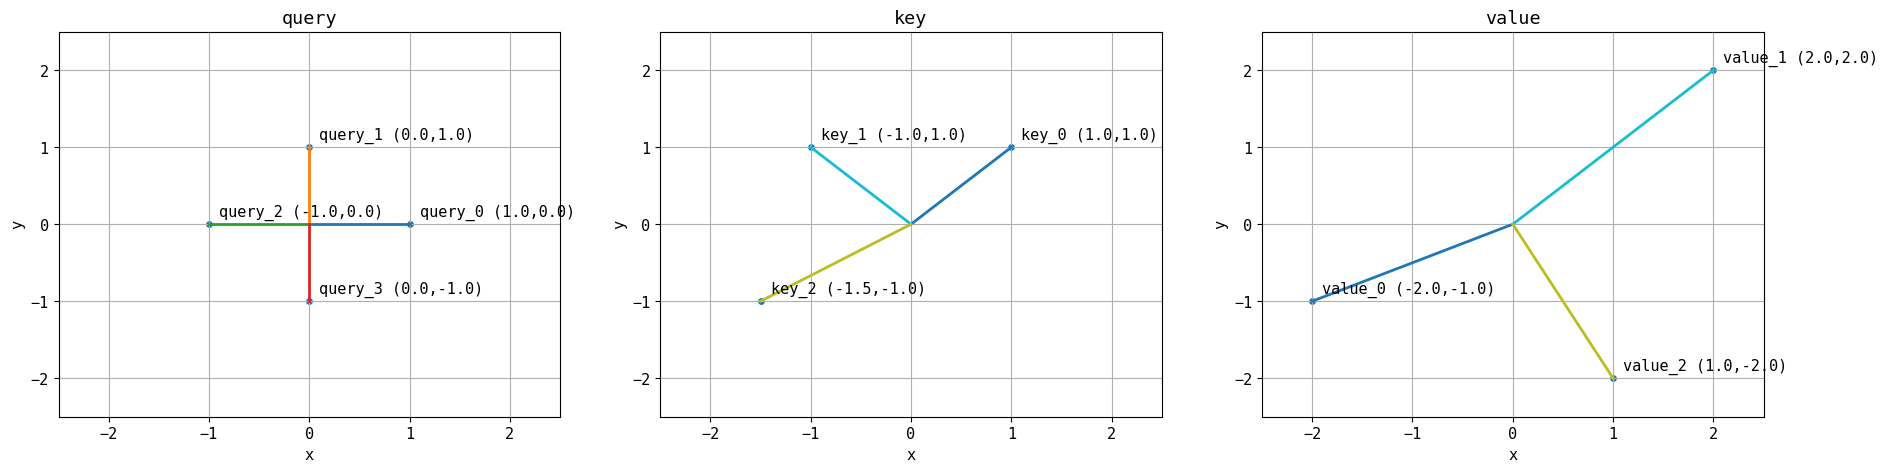

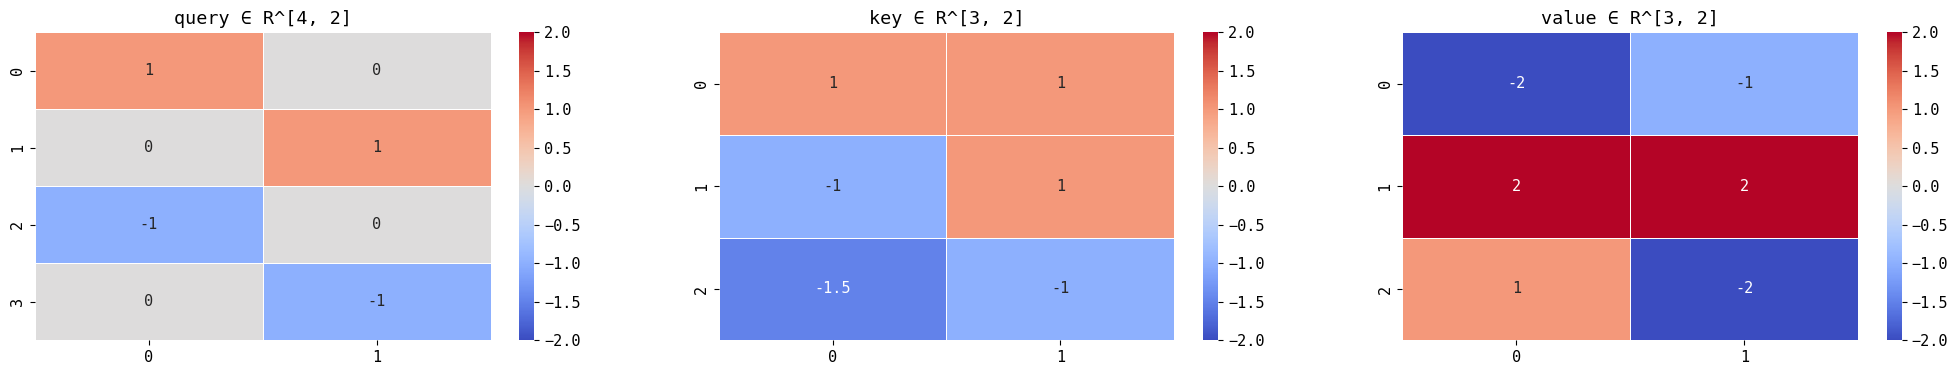

In [5]:
plot_inputs(input_dict)
plot_heatmaps(input_dict, (25,4))

In [ ]:
query.shape, key.shape, value.shape

(torch.Size([4, 2]), torch.Size([3, 2]), torch.Size([3, 2]))

# Compute Attention

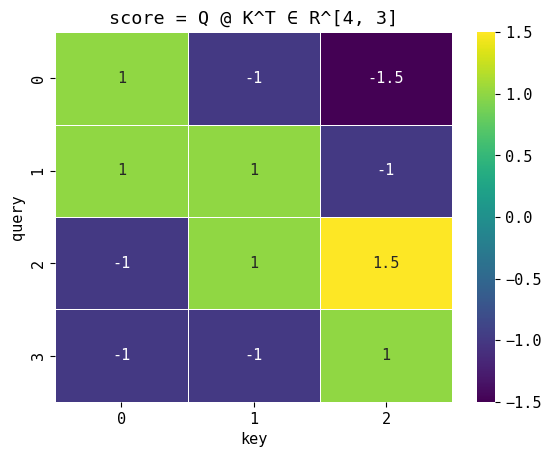

In [ ]:
score = torch.matmul(query, key.transpose(-2,-1)) # Q @ K^T

ax = sns.heatmap(score, linewidth=0.5, cmap="viridis", annot=True)
ax.set(ylabel="query", xlabel="key", title=f"score = Q @ K^T ∈ R^{list(score.size())}")
plt.show()

In [ ]:
query.size(-1), math.sqrt(query.size(-1))

(2, 1.4142135623730951)

Try to understand what changes if you change the scaling factor d

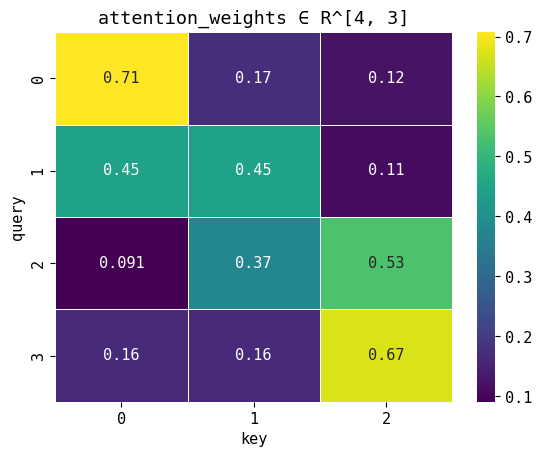

In [ ]:
d = math.sqrt(query.size(-1)) # square root of the token's embedding dimension
scaled_score = score/d
attention_weights = F.softmax(scaled_score, dim=-1)
ax = sns.heatmap(attention_weights, linewidth=0.5, cmap="viridis", annot=True)
ax.set(ylabel="query", xlabel="key", title=f"attention_weights ∈ R^{list(attention_weights.size())}")
plt.show()

In [ ]:
output = torch.matmul(attention_weights, value)
input_dict["output"] = output

input_heatmaps = {
    "Q": query,
    "K^T": key.transpose(-1,-2),
    "Q @ K^T": score,
    "attention_weights": attention_weights,
    "V": value,
    "output": output
}



# Visualize Attention

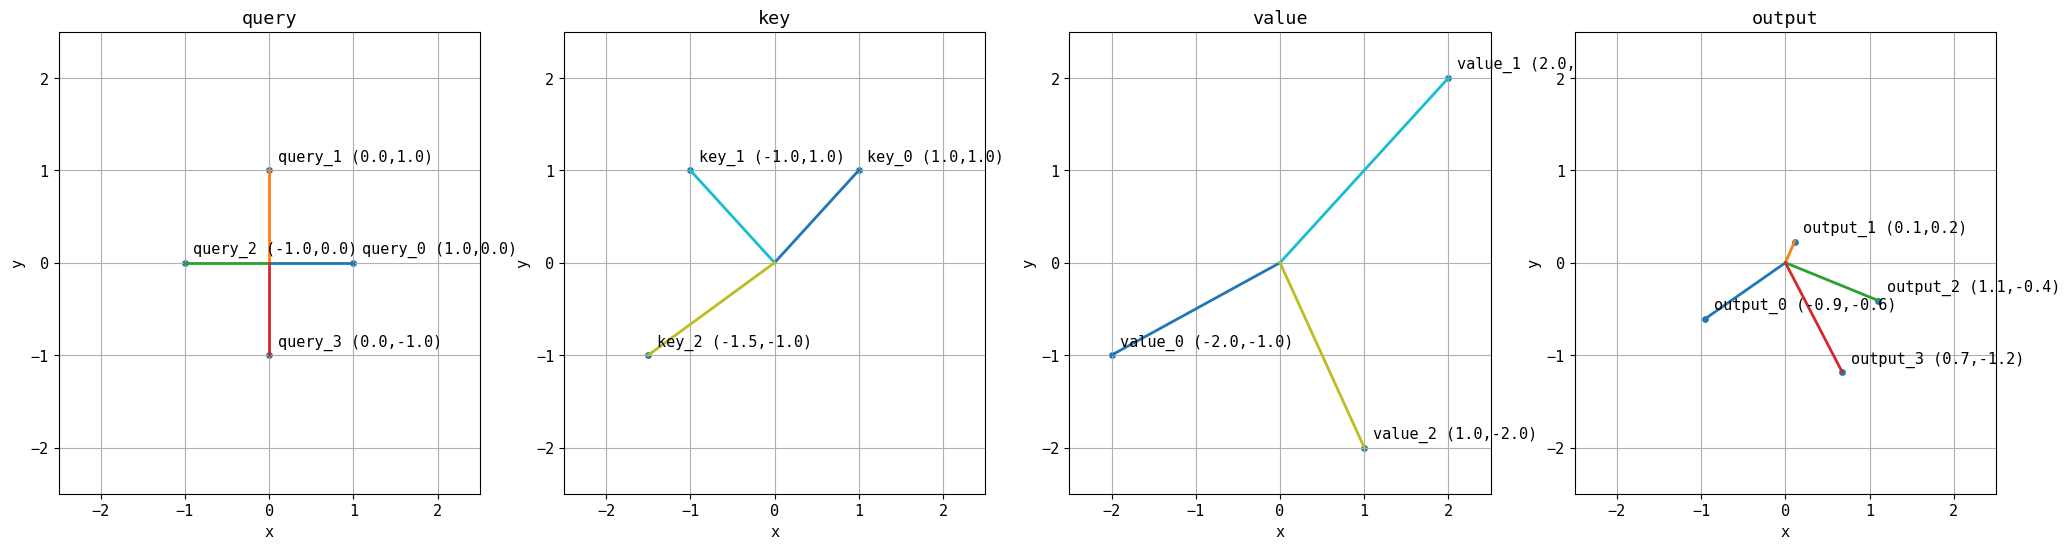

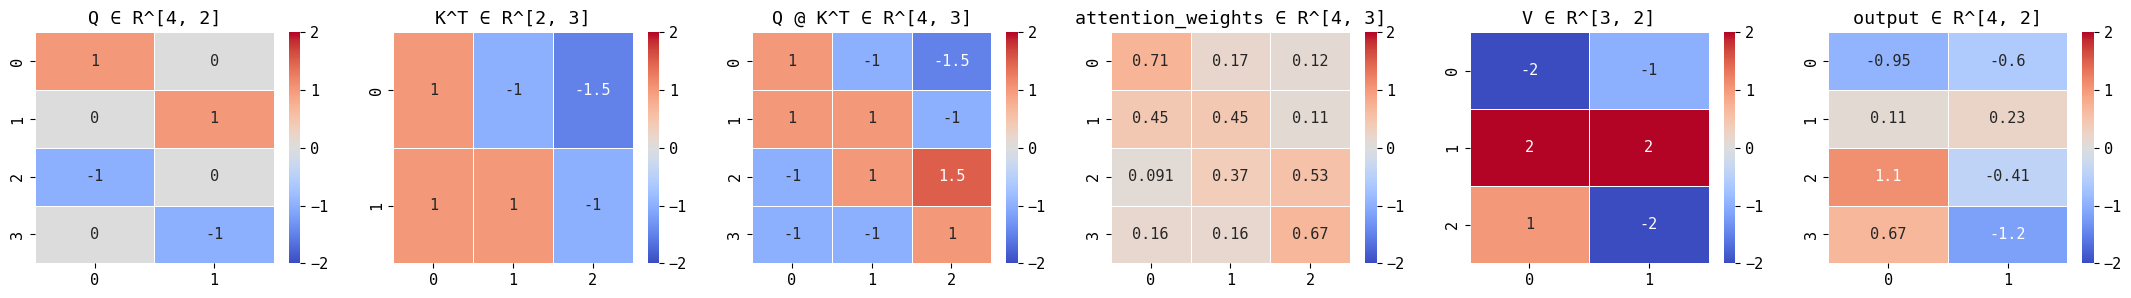

In [ ]:
plot_inputs(input_dict, (25,6))

plot_heatmaps(input_heatmaps, (27,3))

# Compute Masked Attention

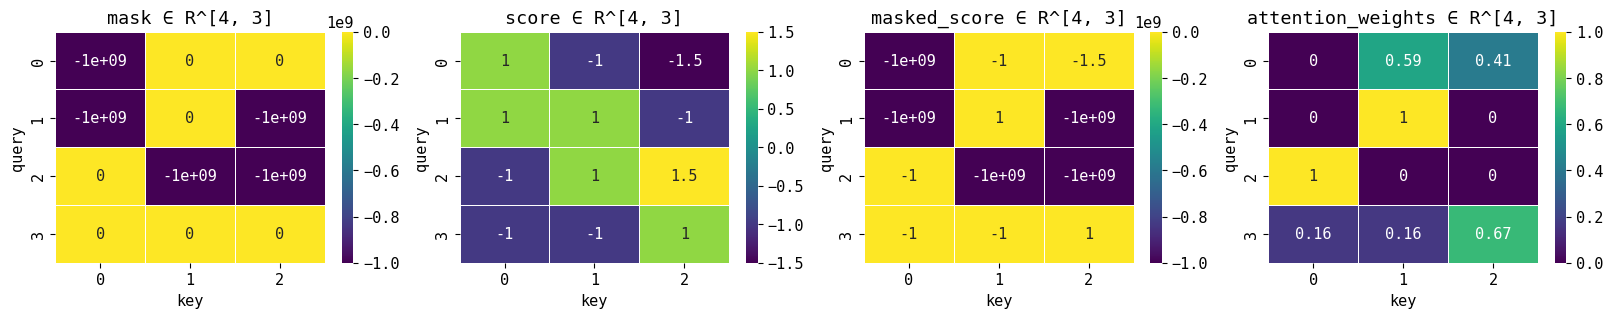

In [ ]:
mask = torch.tensor(
    [
        [-1e9,    0,    0],
        [-1e9,    0, -1e9],
        [   0, -1e9, -1e9],
        [   0,    0,    0]
    ]
)

fig, axs = plt.subplots(1, 4, figsize=(20,3))

mask = mask[:query.shape[0]] # always check if this operation is legal #  the mask must have the same dimension of the score matrix, hence check the correct number of rows/cols
sns.heatmap(mask, linewidth=0.5, cmap="viridis", annot=True, ax=axs[0])
axs[0].set(ylabel="query", xlabel="key", title=f"mask ∈ R^{list(mask.size())}")

sns.heatmap(score, linewidth=0.5, cmap="viridis", annot=True, ax=axs[1])
axs[1].set(ylabel="query", xlabel="key", title=f"score ∈ R^{list(score.size())}")

masked_score = score + mask
sns.heatmap(masked_score, linewidth=0.5, cmap="viridis", annot=True, ax=axs[2])
axs[2].set(ylabel="query", xlabel="key", title=f"masked_score ∈ R^{list(masked_score.size())}")

scaled_score = masked_score/d
attention_weights = F.softmax(scaled_score, dim=-1)
sns.heatmap(attention_weights, linewidth=0.5, cmap="viridis", annot=True, ax=axs[3])
axs[3].set(ylabel="query", xlabel="key", title=f"attention_weights ∈ R^{list(attention_weights.size())}")

plt.show()



In [ ]:
output = torch.matmul(attention_weights, value)
input_dict["output"] = output

input_heatmaps = {
    "Q": query,
    "K^T": key.transpose(-1,-2),
    "Q @ K^T": score,
    "masked_score": masked_score,
    "attention_weights": attention_weights,
    "V": value,
    "output": output
}


# Visualize Masked Attention

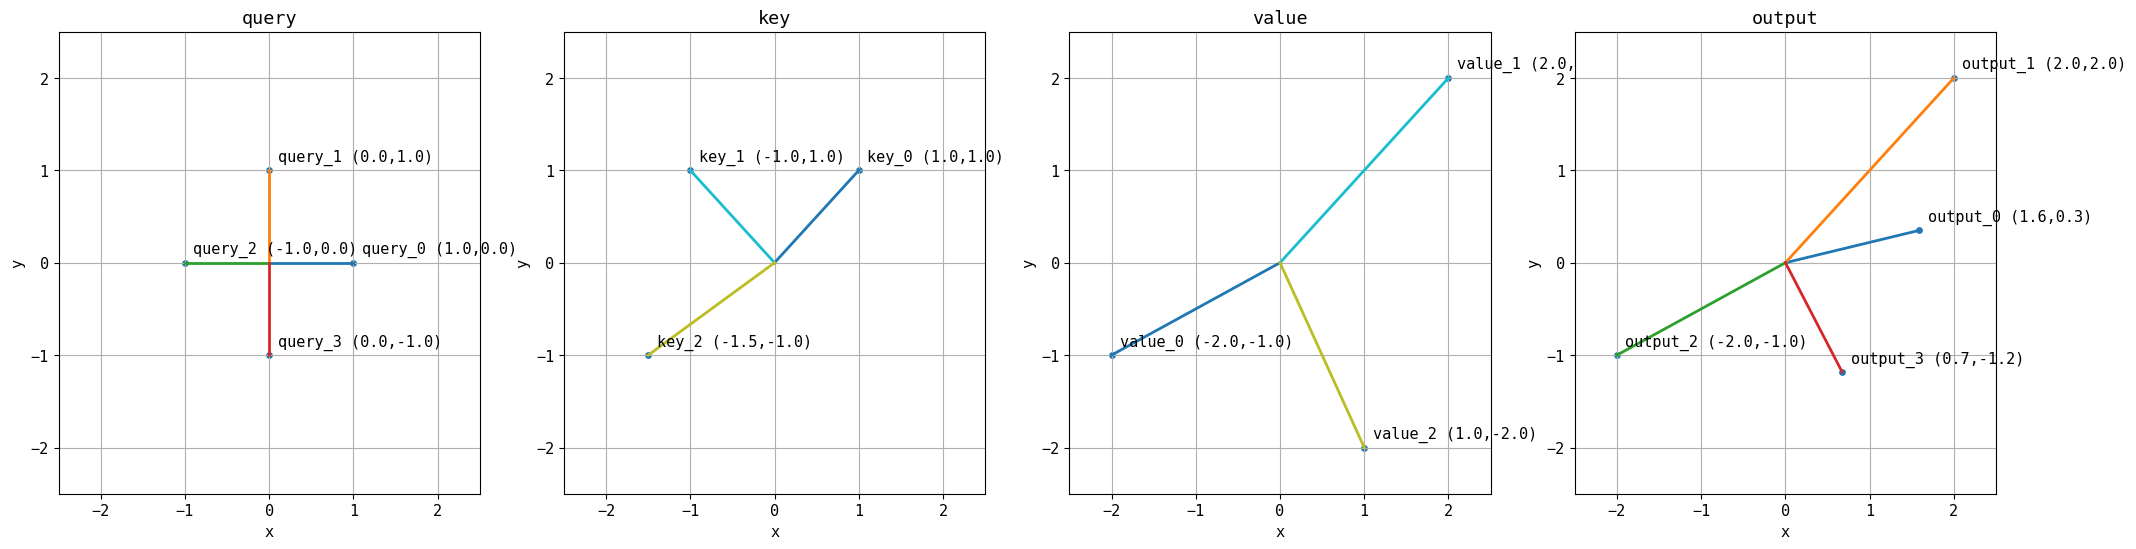

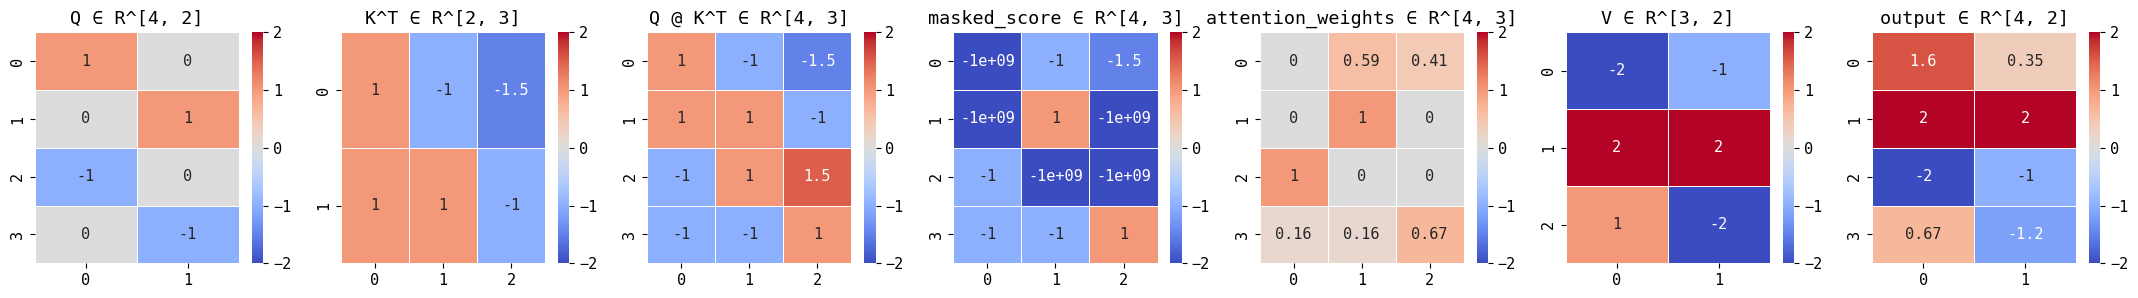

In [ ]:
plot_inputs(input_dict, (25,6))

plot_heatmaps(input_heatmaps, (27,3))